# Demonstration of the IEKS based probabilistic ODE solver

The details of the method can be found in [1].

[1] Filip Tronarp, Simo Särkkä, and Philipp Hennig (2021). Bayesian ODE Solvers: The Maximum A Posteriori Estimate Statistics and Computing 31, 23. 

## Imports

In [1]:
# get the necessary packages
import numpy as np
from scipy import linalg
import jax
import jax.numpy as jnp
from jax.config import config
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import odeint

config.update("jax_enable_x64", True)

## Define the model and solve the ODE using a classical approach

(100, 2)


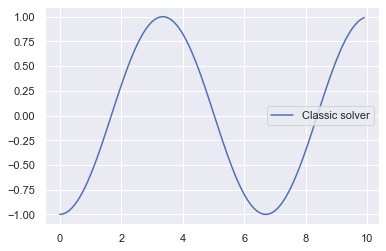

In [6]:
def odefun(x):
    return jnp.stack([x[1], -jnp.sin(x[0])])

x0 = jnp.array([-1.0,0.0])
dt = 0.1
steps = 100
tt = jnp.arange(0, dt * steps, dt)

sol = odeint(lambda t,x: odefun(x), x0, tt, tfirst=True)
print(sol.shape)

sns.set()
plt.plot(tt, sol[:,0], label='Classic solver')
plt.legend()

## IEKS based solution

This is an iterated extended Kalman smoother (IEKS) for the model

$$
  \mathbf{x}_k = \mathbf{A} \, \mathbf{x}_{k-1} + \mathbf{q}_{k-1}
$$
$$
  \mathbf{z}_k = \mathbf{C} \, \mathbf{x}_{k} - \mathbf{f}(\mathbf{H}  \, \mathbf{x}_{k}) + \mathbf{e}_k
$$


In [7]:
def ieks_ode_solver(x0, dt, steps, f, niter=1, q=1.0, p0=1.0, c=1.0):

    #
    # Stacked integrated Wiener process priors for the components
    #
    n = x0.shape[0]

    A_1 = jnp.array([[1.0,dt],[0.0,1.0]])
    Q_1 = q * jnp.array([[dt**3/3.0,dt**2/2.0],[dt**2/2.0,dt]])

    A = np.kron(A_1,jnp.eye(n))
    Q = np.kron(Q_1,jnp.eye(n))
    H = np.kron(np.array([[1.0,0.0]]),jnp.eye(n))  # Picks the actual components
    C = np.kron(np.array([[0.0,1.0]]),jnp.eye(n))  # Picks the time derivatives    

    iQ = linalg.inv(Q)
    
    # We measure C x - f(H x) = 0
    def g(x):
        return C @ x - f(H @ x)
  
    # Function for computing a couple of errors
    def comp_errors(x_list):
        cons_err = 0.0
        pred_err = 0.0
        
        for k in range(0, steps):
            x = x_list[k,:]
            
            g_val = g(x)            
            cons_err = cons_err + 0.5 * np.dot(g_val, g_val)
            if k > 0:
                prev_x = x_list[k-1,:]        
                pred_err = pred_err + 0.5 * (x - prev_x) @ iQ @ (x - prev_x)

        cons_err = cons_err / steps
        pred_err = pred_err / (steps-1)
        
        return cons_err, pred_err
    

    #
    # Iterated extended Kalman smoother
    #
    dg = jax.jacfwd(g)  # Autodiff of the measurement model
    
    m0 = jnp.concatenate([x0, jnp.zeros(n)], axis=0)
    P0 = linalg.block_diag(jnp.zeros((n,n)), p0 * jnp.eye(n))

    nominal = np.empty((steps, 2*n))

    for iter in range(niter):
        # Initialize
        m = m0
        P = P0

        m_list = np.empty((steps, A.shape[0]))
        P_list = np.empty((steps, A.shape[0], A.shape[0]))

        m_list[0,:] = m
        P_list[0,:,:] = P

        # Do the EKF pass
        for k in range(1, steps):
            m = A @ m
            P = A @ P @ A.T + Q

            if iter == 0:
                mn = m
            else:
                mn = nominal[k,:]
                
            G_val = dg(mn)
            g_val = g(mn) + G_val @ (m - mn)

            S = G_val @ P @ G_val.T
            K = linalg.solve(S, G_val @ P).T

            m = m + K @ (-g_val)
            P = P - K @ S @ K.T

            m_list[k,:] = m
            P_list[k,:,:] = P

        cons_err, pred_err = comp_errors(m_list)
        print(f"{iter = } EKF: {cons_err = :.4g}, {pred_err = :.4g}")            
            
        ms_list = m_list.copy()
        Ps_list = P_list.copy()
        ms = m_list[-1,:]
        Ps = P_list[-1,:,:]

        sol = np.empty((steps, n))
        sol_cov = np.empty((steps, n, n))

        # Do the smoother pass
        for k in range(steps-1,-1,-1):
            m = m_list[k,:]
            P = P_list[k,:,:]

            mp = A @ m
            Pp = A @ P @ A.T + Q

            Gk = linalg.solve(Pp, A @ P).T
            ms = m + Gk @ (ms - mp)
            Ps = P + Gk @ (Ps - Pp) @ Gk.T

            ms_list[k,:] = ms
            Ps_list[k,:,:] = Ps
            
            sol[k, :] = H @ ms
            sol_cov[k, :, :] = H @ Ps @ H.T
        
        cons_err, pred_err = comp_errors(ms_list)
        print(f"{iter = } EKS: {cons_err = :.4g}, {pred_err = :.4g}")

        # Do a simple damped update, c = 1.0 is a full update
        if iter == 0:
            nominal = ms_list.copy()
        else:
            nominal = (1 - c) * nominal + c * ms_list
        
    return sol, sol_cov
    
    

In [8]:
dt_ieks = 0.2
steps_ieks = 50
tt_ieks = jnp.arange(0, dt_ieks * steps_ieks, dt_ieks)

sol_ieks, sol_ieks_cov = ieks_ode_solver(x0, dt_ieks, steps_ieks, odefun, niter=5, q=1.0, p0=1.0, c=1)

iter = 0 EKF: cons_err = 0.007081, pred_err = 22.87
iter = 0 EKS: cons_err = 0.0008133, pred_err = 21.38
iter = 1 EKF: cons_err = 0.007082, pred_err = 22.83
iter = 1 EKS: cons_err = 0.0008408, pred_err = 21.21
iter = 2 EKF: cons_err = 0.007082, pred_err = 22.82
iter = 2 EKS: cons_err = 0.0008432, pred_err = 21.19
iter = 3 EKF: cons_err = 0.007082, pred_err = 22.82
iter = 3 EKS: cons_err = 0.0008436, pred_err = 21.19
iter = 4 EKF: cons_err = 0.007082, pred_err = 22.82
iter = 4 EKS: cons_err = 0.0008437, pred_err = 21.19


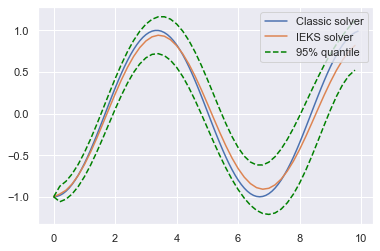

In [9]:
plt.plot(tt, sol[:,0], label='Classic solver')
plt.plot(tt_ieks, sol_ieks[:,0], label='IEKS solver', linestyle='-')
plt.plot(tt_ieks, sol_ieks[:,0] + 1.96 * np.sqrt(sol_ieks_cov[:,0,0]), label='95% quantile',
         linestyle='--', color='green')
plt.plot(tt_ieks, sol_ieks[:,0] - 1.96 * np.sqrt(sol_ieks_cov[:,0,0]), linestyle='--', color='green')
plt.legend()